# Simple Siamese network

## Import modules

In [9]:
import pandas as pd
import os
import numpy as np
import csv
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


mnist_path= "../resources/mnist.csv"

## Read mnist csv to memory

In [6]:
NUMBER_OF_IMAGES_TO_READ_FROM_CSV=int(1.0 * 60000)
NUMBER_OF_POS_PAIRS=5400
NUMBER_OF_NEG_PAIRS=5400


# code
print(f"Reading {NUMBER_OF_IMAGES_TO_READ_FROM_CSV} images from csv...\n")

label_image=[ 
    # {'label': 3, 'img':np.array(28x28) }
]
with open(mnist_path, "r") as csv_file:
    reader = csv.reader(csv_file)
    for i in range(NUMBER_OF_IMAGES_TO_READ_FROM_CSV):
        row = next(reader)
        # print(len(row),row,end="\n\n")

        label= int(row[0])
        image= np.array( [int(p) for p in row[1:] ] ).reshape((28,28))
        
        label_image.append({
            'label':label,
            'image':image
        })


#So after previous cell we have label_image which is a list of dicts:
# ```
# [
#     { 'label': 3, 'img': np.array(28x28)},
#     { 'label': 1, 'img': np.array(28x28)}
# ...
# ]
# ```
# Now we gotta create pairs out of that

# variable holding dataset called **img_img_label** is breated here

img_img_label=[
    # [np.array(), np.array(), 1]
]

log=False
elements_used=0

for label in [0,1,2,3,4,5,6,7,8,9]:
    if log: print(f"Creating pairs for label {label}")
    n_positive_pairs=0
    n_negative_pairs=0

    img_A=None
    get_first_img=True
    pos_neg=None
    for i, lbl_img in enumerate(label_image):

        if i>elements_used:
            elements_used=i

        if lbl_img['label'] == label:  # if label positive
            if get_first_img:
                if log: print(f"\tFound first img_A")
                img_A= lbl_img['image']
                get_first_img=False
            
            elif n_positive_pairs < NUMBER_OF_POS_PAIRS :
                if log: print(f"\tFound positive img_B", end="  ")
                if img_A is not None:
                    if log: print(f"adding")
                    n_positive_pairs+=1
                    img_img_label.append(
                        [img_A, lbl_img['image'], 1]
                    )
                else:
                    if log: print(f"skipping (no img_A yet)")
               
        
        elif n_negative_pairs < NUMBER_OF_NEG_PAIRS :
            if log: print(f"\tFound negative img_B", end="  ")
            if img_A is not None:
                    if log: print(f"adding")
                    n_negative_pairs+=1
                    img_img_label.append(
                        [img_A, lbl_img['image'], 0]
                    )
            else:
                if log: print(f"skipping (no img_A yet)")
       
        if n_negative_pairs>=NUMBER_OF_POS_PAIRS and n_positive_pairs>= NUMBER_OF_NEG_PAIRS:
            break
    
            
if len(img_img_label) == 10*(NUMBER_OF_POS_PAIRS + NUMBER_OF_NEG_PAIRS):
    print(f"Sucess: {len(img_img_label)} pairs created. Used {100*elements_used/NUMBER_OF_IMAGES_TO_READ_FROM_CSV:.0f}% of read images")
else:
    print(f"Fail: {len(img_img_label)} pairs build of of {10*(NUMBER_OF_POS_PAIRS + NUMBER_OF_NEG_PAIRS)} required. \nSome pairs missing. Try reading more rows from csv file\n Used {100*elements_used/NUMBER_OF_IMAGES_TO_READ_FROM_CSV}%  of read images")

del label_image, log, elements_used

Reading 60000 images from csv...

Sucess: 108000 pairs created. Used 100% of read images


---
After running previous cell we have list called **img_img_label**  
It is a list of lists, structured as follows:  
```
[
    [img_A, img_B, label],
    [img_A, img_B, label],
    [img_A, img_B, label],
    ...
]

```
where:  
- `img_A` is a numpy array containing first  image (grayscale, shape (28x28))  
- `img_B` is a numpy array containing second image (grayscale, shape (28x28))  
- `label` is an integer, is equal to 0 if images contain diffrent digits, is equal to 1 if images are the same  

### Show image pairs

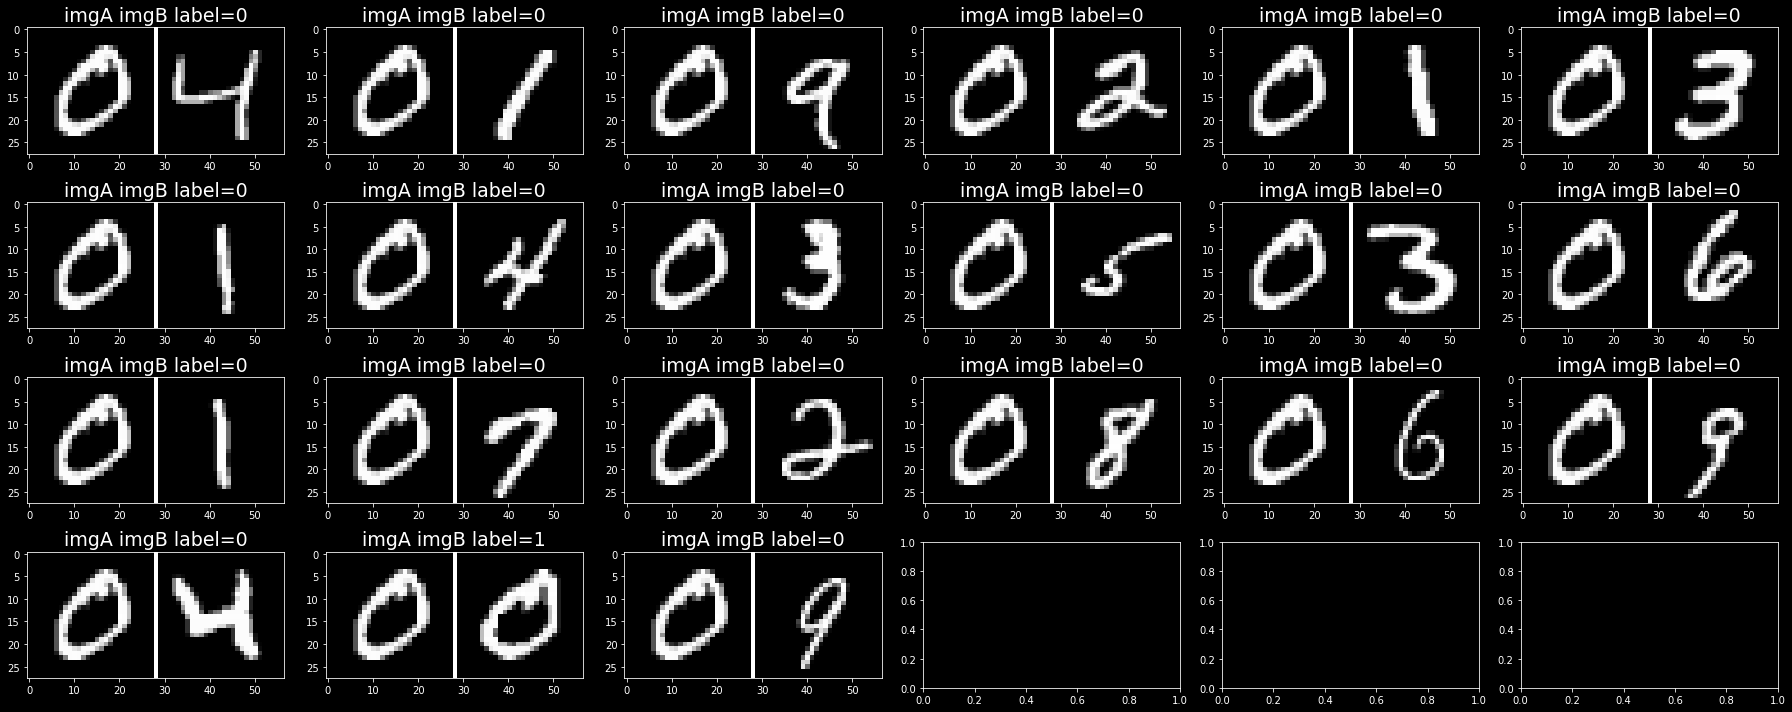

In [33]:
SHOW_FIRST_N_PAIRS=20

cols= 6
rows= 1+ SHOW_FIRST_N_PAIRS//cols
plt.style.use('dark_background')

fig= plt.figure(figsize=(25,10))
axes=fig.subplots(rows,cols).ravel()
i=0
for imgA, imgB, label in img_img_label:
    mashed_imgAB=  np.concatenate((imgA,255*np.ones((28,1)),imgB), axis=1)
    axes[i].imshow(mashed_imgAB, cmap='gray')
    axes[i].set_title(f"imgA imgB label={label}", fontsize=19)
    i+=1
    if i > SHOW_FIRST_N_PAIRS: break
fig.tight_layout()


Now we have a list of lists with data where:
```
[
    [np.array(28x28), np.array(28x28), 1],
    [np.array(28x28), np.array(28x28), 0],
]

```
## Building data generators for SNN

In [7]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, list_imgA_imgB_label, batch_size= 1, shuffle=False) -> None:
        """Creates generator.

        Args:
            list_imgA_imgB_label (list): list of lists where each dublist is [imgA, imgB, label] 
            shuffle (_type_): if True than shuffeling data after epoch.
            batch_size (int, optional): Size of batch. Defaults to 1.
        """

        self.data                   = list_imgA_imgB_label
        self.batch_size             = batch_size
        self.shuffle                = shuffle
        self.indices                = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        """Returns number of batches in the dataset.

        Returns:
            int: _description_
        """
        return len(self.data) // self.batch_size

    def __getitem__(self, index):
        """The __getitem__ method is called by TensorFlow to get a batch of training data for each iteration of training. It takes an index as input, which represents the index of the batch to return.

        Args:
            index (_type_): _description_

        Returns:
            _type_: _description_
        """
        batch_indices = self.indices[index * self.batch_size  :  (index + 1) * self.batch_size]
        batch_data = [self.data[idx] for idx in batch_indices] # list of [imgA, imgB, label]  i.e. [np.array(28x28), np.array(28x28), int]

        X1      = [sample[0] for sample in batch_data]
        X2      = [sample[1] for sample in batch_data]
        y_list  =  [sample[2] for sample in batch_data]

        X1 = np.array(X1).reshape(-1, 28, 28, 1)
        X2 = np.array(X2).reshape(-1, 28, 28, 1)
        Y  = np.array(y_list) 

        X1_tensor = tf.convert_to_tensor(X1, dtype=tf.float32)
        X2_tensor = tf.convert_to_tensor(X2, dtype=tf.float32)
        Y_tensor  = tf.convert_to_tensor(Y,  dtype=tf.float32)

        return [X1_tensor, X2_tensor], Y_tensor

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create train and validation generators
split_idx= int(0.9*len(img_img_label))
test_idx_start= split_idx+ (len(img_img_label)-split_idx)//2
train_generator     = DataGenerator(img_img_label[:split_idx], batch_size=64, shuffle=True)
validation_generator= DataGenerator(img_img_label[split_idx:test_idx_start], batch_size=1024, )
test_generator      = DataGenerator(img_img_label[test_idx_start:], batch_size=1024, )
print(f"N of batches: {len(train_generator)=}  {len(validation_generator)=}   {len(test_generator)=}")
        

N of batches: len(train_generator)=1518  len(validation_generator)=5   len(test_generator)=5


In [12]:
# Test generator, get first batch
for batch in train_generator:
    print(f"{type(batch)=}")
    print(f"{len(batch)=}")
    print()
    print(f"\t{type(batch[0])=}")
    print(f"\t{len(batch[0])=}")
    print(f"\t\t{type(batch[0][0])=}")
    print(f"\t\t{batch[0][0].shape=}")
    print()
    print(f"\t\t{type(batch[0][1])=}")
    print(f"\t\t{batch[0][1].shape=}")

    print()
    print(f"{type(batch[1])=}")
    print(f"{batch[1].shape=}")
    break
    # print(f"Batch {i} inputs shape: {inputs.shape}")
    # print(f"Batch {i} targets shape: {targets.shape}")

type(batch)=<class 'tuple'>
len(batch)=2

	type(batch[0])=<class 'list'>
	len(batch[0])=2
		type(batch[0][0])=<class 'tensorflow.python.framework.ops.EagerTensor'>
		batch[0][0].shape=TensorShape([32, 28, 28, 1])

		type(batch[0][1])=<class 'tensorflow.python.framework.ops.EagerTensor'>
		batch[0][1].shape=TensorShape([32, 28, 28, 1])

type(batch[1])=<class 'tensorflow.python.framework.ops.EagerTensor'>
batch[1].shape=TensorShape([32])


## SNN architecture

In [2]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    loss = tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return loss

In [15]:
def create_SSN_model(input_shape=(28, 28, 1)):

    # Create feature_extractor, (common part of SNN)
    input_layer = Input(shape=input_shape, name="input")

    x = Conv2D(128, (7, 7), activation='relu', name="conv1")(input_layer)
    x = MaxPooling2D((2, 2), name="max_pool1")(x)
    x = Conv2D(64, (3, 3), activation='relu', name="conv2")(x)
    # x = MaxPooling2D((2, 2), name="max_pool2")(x)
    x = Dropout(0.4, name="dropout1")(x)
    x = Flatten(name="flatten")(x)
    x = Dense(64, activation='relu', name="fully_connected1")(x)
    x = Dropout(0.5, name="dropout2")(x)
    x = Dense(32, activation='relu', name="fully_connected2")(x)
    x = Dropout(0.5, name="dropout3")(x)
    x = Dense(16, activation='relu', name="fully_connected3")(x)

    embedding = Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name="normalize")(x)

    feature_extractor = Model(inputs=input_layer, outputs=embedding, name="feature_extractor")


    # Assemble SSN
    input_a = Input(shape=input_shape, name="input_a")
    input_b = Input(shape=input_shape, name="input_b")

    processed_a = feature_extractor(input_a)
    processed_b = feature_extractor(input_b)

    distance = Lambda(lambda x: tf.math.abs(x[0] - x[1]), name="euclidean") ([processed_a, processed_b], )
    output = Dense(1, activation='sigmoid', name="sigmoid_output")(distance)

    model = Model(inputs=[input_a, input_b], outputs=output, name="SSN")

    return model

model= create_SSN_model()
model.summary()
model.compile(
    loss=contrastive_loss,
    optimizer=Adam(lr=0.0001),
    metrics= [
        'accuracy',
    ]
)

print("\nfeature_extractor")
feature_extractor = model.get_layer("feature_extractor")
feature_extractor.summary()

Model: "SSN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_b (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
feature_extractor (Functional)  (None, 16)           414640      input_a[0][0]                    
                                                                 input_b[0][0]                    
__________________________________________________________________________________________________
euclidean (Lambda)              (None, 16)           0           feature_extractor[0][0]        

## load saved model

In [3]:
path_to_model="../resources/saved_models/2"
model = tf.keras.models.load_model(path_to_model, custom_objects={'contrastive_loss': contrastive_loss})

## Train

In [1]:
%load_ext tensorboard

# %reload_ext tensorboard

%tensorboard --logdir ../resources/train_logs

Reusing TensorBoard on port 6006 (pid 12164), started 0:03:46 ago. (Use '!kill 12164' to kill it.)

In [16]:
train_log_dir= "../resources/train_logs/"
# Create new dir for new output
dir_cnt=len(next(os.walk(train_log_dir))[1])
log_dir = train_log_dir + f"{dir_cnt+1}"
f"{log_dir=}"

"log_dir='../resources/train_logs/2'"

In [19]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = tf.keras.callbacks.CSVLogger(log_dir+'/training.csv', separator=',', append=True)


history= model.fit(
    x= train_generator, 
    validation_data=validation_generator,
    initial_epoch=30,
    epochs=40,
    callbacks=[tensorboard_callback, csv_logger],
    verbose=2
)


Epoch 31/40
2250/2250 - 229s - loss: 0.1038 - accuracy: 0.8695 - val_loss: 0.1010 - val_accuracy: 0.9300
Epoch 32/40
2250/2250 - 237s - loss: 0.1039 - accuracy: 0.8695 - val_loss: 0.1019 - val_accuracy: 0.9350
Epoch 33/40
2250/2250 - 230s - loss: 0.1040 - accuracy: 0.8693 - val_loss: 0.0730 - val_accuracy: 0.9499
Epoch 34/40
2250/2250 - 230s - loss: 0.1041 - accuracy: 0.8690 - val_loss: 0.0740 - val_accuracy: 0.9473
Epoch 35/40
2250/2250 - 231s - loss: 0.1032 - accuracy: 0.8700 - val_loss: 0.0746 - val_accuracy: 0.9459
Epoch 36/40
2250/2250 - 233s - loss: 0.1028 - accuracy: 0.8709 - val_loss: 0.1146 - val_accuracy: 0.9327
Epoch 37/40
2250/2250 - 253s - loss: 0.1031 - accuracy: 0.8704 - val_loss: 0.1874 - val_accuracy: 0.6267
Epoch 38/40
2250/2250 - 243s - loss: 0.1036 - accuracy: 0.8698 - val_loss: 0.0744 - val_accuracy: 0.9435
Epoch 39/40
2250/2250 - 243s - loss: 0.1030 - accuracy: 0.8702 - val_loss: 0.0795 - val_accuracy: 0.9404
Epoch 40/40
2250/2250 - 246s - loss: 0.1028 - accuracy:

## Plot training curves

In [29]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df= pd.read_csv("../resources/train_logs/2/training.csv")
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter( y=df['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=df['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=df['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

### Save and Load Model

In [20]:
model.save("../resources/saved_models/2/")

INFO:tensorflow:Assets written to: ../resources/saved_models/2/assets


### Resume Training

In [10]:
log_dir = "logs/fit/9" 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x= train_generator, 
    validation_data=validation_generator,
    initial_epoch=60,
    epochs=90,
    callbacks=[tensorboard_callback]
)

# Assess model performance

In [41]:
y_true = []
y_pred = []
for X, y in test_generator:
    y_true.extend(y)
    y_pred_probs = model.predict(X)
    y_pred.extend(np.where(y_pred_probs > 0.5, 1, 0))

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8958984375
Precision: 1.0
Recall: 0.8837767117313563
F1-score: 0.9383030443338349


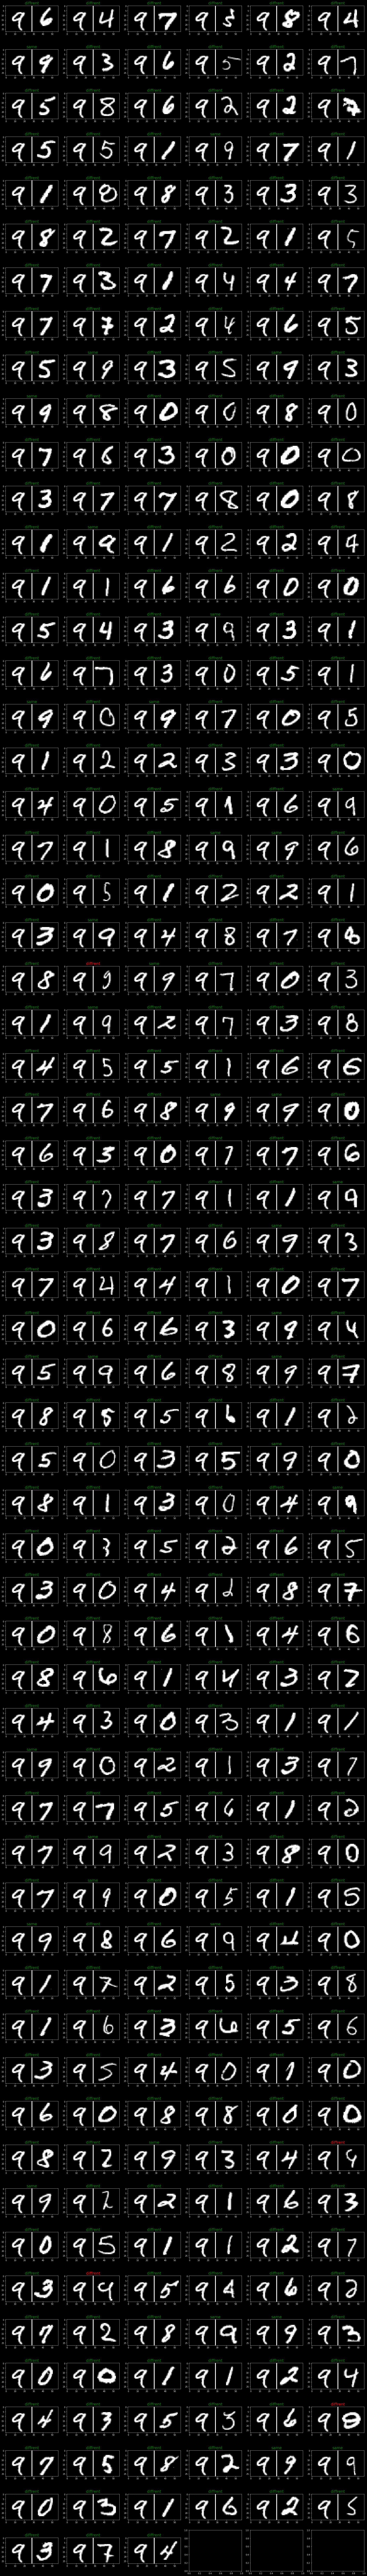

In [43]:
N_OF_EXAMPLES_TO_INSPECT=350


cols= 6
rows= 1+ N_OF_EXAMPLES_TO_INSPECT//cols
plt.style.use('dark_background')
fig= plt.figure(figsize=(25,N_OF_EXAMPLES_TO_INSPECT//2))
axes=fig.subplots(rows,cols).ravel()

i=0
for [X1, X2], _ in test_generator: # X1 and X2 are tensors (1024, 28, 28, 1)

    for j in range( X1.shape[0] ): # iterating over batch of 1024 images
        img_A = X1[j,:,:,0].numpy()
        img_B = X2[j,:,:,0].numpy()

        mashed_imgAB=  np.concatenate((img_A,255*np.ones((28,1)),img_B), axis=1)  # concat images together with line between them like A|B 
        axes[i].imshow(mashed_imgAB, cmap='gray') 
        color= 'g' if y_pred[i]==y_true[i] else 'r'
        out= 'same' if y_pred[i]==1 else 'diffrent'
        axes[i].set_title(f"{out}", fontsize=19, color=color)
        if i >= N_OF_EXAMPLES_TO_INSPECT:
            break
        else:
            i+=1

    if i >= N_OF_EXAMPLES_TO_INSPECT:
        break
fig.tight_layout()
